---

### Recurrent Neural Network

In [2]:
#import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np
import re

In [17]:
categories = ['talk.politics.guns', 'soc.religion.christian']

In [18]:
data = fetch_20newsgroups(categories=categories, remove=['headers', 'footers'])

In [5]:
#data = fetch_20newsgroups(remove=['headers', 'footers'])

In [11]:
data.keys

<function Bunch.keys>

In [20]:
X = data['data']

In [19]:
#y = data['target_names']

In [22]:
y = data['target'] #0 means christianity, 1 means guns
y

array([0, 0, 0, ..., 1, 1, 0])

In [23]:
y[:10]

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 1])

In [ ]:
data

### Text preprocessing 

* split 
* drop special characters and stop words
* tokenisation
* vectorize = we'll use keras embedding layer for that

In [31]:
def clean_text(text,label,cap):
    clean_text = []
    clean_label = []
    for i, email in enumerate(text):
        email = email.lower()
        email = re.findall('(?u)\\b\\w\\w+\\b', email)
        if len(email) <= cap:
            clean_text.append(email)
            clean_label.append(label[i])
    return clean_text, clean_label

In [ ]:
# we could split the long emails, or we could drop them

In [29]:
sorted([len(x) for x in X])[-1]

70849

In [32]:
clean_X , clean_y = clean_text(X,y,300)

#### Make a vocab list

In [35]:
vocab_list = []
for email in clean_X:
    for word in email:
        vocab_list.append(word)
        
vocab_list = list(set(vocab_list))
vocab_size = len(vocab_list) + 1

#### Make a dictionary for words to numbers

In [38]:
word_to_num = {}

for i, word in enumerate(vocab_list):
    word_to_num[word] = i+1 #i+1 because we're reserving 0 for blank space

In [40]:
vec_X = [[word_to_num[word] for word in email] for email in clean_X]

#### find the max length of the text, then pad all seqeunces to match that length - input shape in NN has to be consistent!!

In [39]:
max_len = 0
position = 0
for i, email in enumerate(clean_X):
    if len(email) > max_len:
        max_len = len(email)
        position = i
max_len, position

(299, 82)

#### Lets pad the sequences

In [44]:
pad_vec_X = sequence.pad_sequences(vec_X, maxlen = max_len, padding = 'pre')

In [45]:
pad_vec_X[5]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

---

#### This is what we've done in RNNs so far
* download test emails
* removed special characters
* transformed the words into numbers
* cast them into a list
* padded them with zeroes so every email number list has the same length

#### This is what we have to do now
* initialise an lstm
* train in on the Xtrain data 
* test it on our Xtest data

In [46]:
from sklearn.model_selection import train_test_split

In [48]:
Xtrain, Xtest, ytrain, ytest = train_test_split(pad_vec_X, np.array(clean_y))

---

#### Now lets create the model
We build a sequential model

Then add an Embedding layer

This layer takes 3 parameters - the size of the vocab (input_dims), the no. of dimensions of each word embedding (output_dim), and the length of each document (input_length), which we've standardised above. It returns a 2d matrix, with rows equal to each word in the document, and columns equal to the number of dimensions in the word embedding. 

*Actually its 3D, cos the batch_size is the first dimension in both input and output, but I find that confuses things more than it clarifies*
Put another way 

The embedding **takes in** a factorized corpus, e.g.:

**[The, cat, sat, on, the, mat]**    becomes    **[1,2,3,4,1,5]**

And **outputs** a word embedded corpus:

**[1,2,3,4,1,5]**    becomes (lets assume output_dim=2)   **[[0.2,0.7], [0.6,0.3], [0.1,0.8], [0.2,0.1], [0.4,0.9], [0.2,0.7]]**

In [50]:
vocab_size

11115

In [49]:
model = Sequential()

In [52]:
model.add(Embedding(input_dim=vocab_size, output_dim = 32, input_length = max_len))

In [ ]:
model.add(LSTM(128)) # units? if no. units > max_len, likely to overfit

In [53]:
model.add(Dense(1, activation = 'sigmoid'))

In [54]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [60]:
history = model.fit(Xtrain, ytrain, epochs = 20, batch_size = 250, validation_split=0.2)

Epoch 1/20
2/2 [==============================] - 0s 26ms/step - loss: 0.6879 - accuracy: 0.5841 - val_loss: 0.6933 - val_accuracy: 0.4857
Epoch 2/20
2/2 [==============================] - 0s 16ms/step - loss: 0.6867 - accuracy: 0.5901 - val_loss: 0.6929 - val_accuracy: 0.4857
Epoch 3/20
2/2 [==============================] - 0s 23ms/step - loss: 0.6857 - accuracy: 0.5931 - val_loss: 0.6923 - val_accuracy: 0.4878
Epoch 4/20
2/2 [==============================] - 0s 19ms/step - loss: 0.6845 - accuracy: 0.5959 - val_loss: 0.6918 - val_accuracy: 0.4883
Epoch 5/20
2/2 [==============================] - 0s 18ms/step - loss: 0.6835 - accuracy: 0.5973 - val_loss: 0.6914 - val_accuracy: 0.4882
Epoch 6/20
2/2 [==============================] - 0s 17ms/step - loss: 0.6825 - accuracy: 0.5982 - val_loss: 0.6909 - val_accuracy: 0.4883
Epoch 7/20
2/2 [==============================] - 0s 18ms/step - loss: 0.6814 - accuracy: 0.5987 - val_loss: 0.6905 - val_accuracy: 0.4885
Epoch 8/20
2/2 [===========

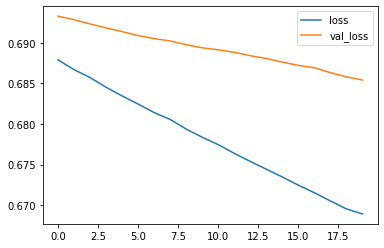

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

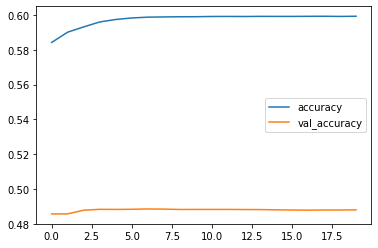

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

In [63]:
model.evaluate(Xtest,ytest)

6/6 [==============================] - 0s 771us/step - loss: 0.6799 - accuracy: 0.5482


[0.6799014210700989, 0.5482497811317444]